In [72]:
# Libraries used
import scipy.io as sio
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend

# 1. Visualization

Load and inspect the .mat files.

Extract and reshape EEG signals converting it to DataFrames.

Each cell = a 3D array [n_subjects, n_samples, n_channels]

In [73]:
def load_group(file_name, group_label, gender):
    # Load .mat files
    data = sio.loadmat(os.path.join('EEG', file_name + '.mat'))
    # Get only the last column where all the information that we need is
    key = list(data.keys())[-1]
    group_data = data[key]

    rows = []
    # Loop through each cell (tasks)
    for task_idx in range(group_data.shape[1]):
        task_data = group_data[0, task_idx]
        n_subjects, n_samples, n_channels = task_data.shape

        for subj_idx in range(n_subjects):
            # Handle corrupted sample (skip female ADHD subject 7)
            if file_name == "FADHD" and subj_idx == 6:
                continue
            
            # This will make it easier to know later to which signal we are referring
            signal = task_data[subj_idx, :, :]  # [samples x channels]
            rows.append({
                "group": group_label,    # 'Control' or 'ADHD'
                "gender": gender,        # 'Male' or 'Female'
                "task": task_idx + 1,    # 1 to 11
                "subject_id": f"{file_name}_{subj_idx+1}",
                "signal": signal
            })
    return pd.DataFrame(rows)

# Load all four groups
fc_df = load_group("FC", group_label="Control", gender="Female")
mc_df = load_group("MC", group_label="Control", gender="Male")
fadhd_df = load_group("FADHD", group_label="ADHD", gender="Female")
madhd_df = load_group("MADHD", group_label="ADHD", gender="Male")

# Combine
eeg_df = pd.concat([fc_df, mc_df, fadhd_df, madhd_df], ignore_index=True)

In [74]:

eeg_df.head()
# print(eeg_df.shape)

,group,gender,task,subject_id,signal
0,Control,Female,1,FC_1,"[[-71.856, -3.104], [-344.555, -63.584], [-255..."
1,Control,Female,1,FC_2,"[[-6.587, 28.138], [-26.127, 52.008], [-14.1, ..."
2,Control,Female,1,FC_3,"[[-149.667, -144.478], [-303.2, -72.021], [-61..."
3,Control,Female,1,FC_4,"[[9.157, 5.49], [-27.11, 25.285], [-14.297, 11..."
4,Control,Female,1,FC_5,"[[13.423, 59.656], [8.419, -14.864], [-4.453, ..."


## Visualization of data

Visual inspection of signals. In the graph below the first subject is plotted, the first task and the firs channel: Eyes open baseline in channel Cz.

The x-axis represents the time (in samples) → 7680 samples = 30 s of recording.

And the y-axis is the EEG amplitude in microvolts (µV).

So the plot represents the time-domain EEG waveform of one electrode (Cz).

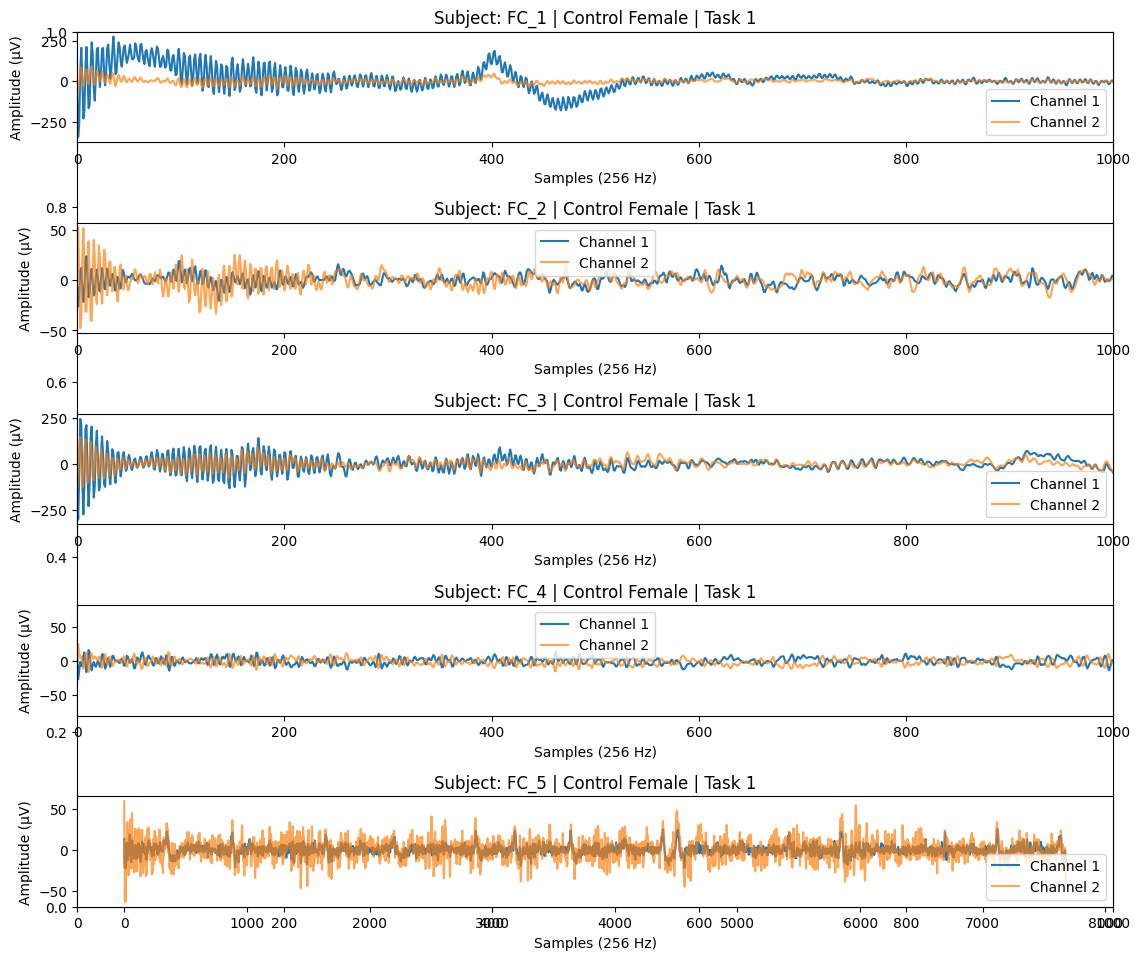

In [75]:
# Visualize the channels of a subject doing a task
def visualize_task(df, group, gender, task=1, n=5):

    subset = df[(df["group"] == group) & (df["gender"] == gender) & (df["task"] == task)].head(n)
    
    if subset.empty:
        print(f"No data found for {group} {gender}, Task {task}")
        return

    plt.figure(figsize=(12, 2 * n))

    for i, (_, row) in enumerate(subset.iterrows(), start=1):
        signal = row["signal"]
        
        plt.xlim(0, 1000)
        plt.subplot(n, 1, i)
        plt.plot(signal[:, 0], label="Channel 1")
        plt.plot(signal[:, 1], label="Channel 2", alpha=0.7)
        plt.title(f"Subject: {row['subject_id']} | {group} {gender} | Task {task}")
        plt.xlabel("Samples (256 Hz)")
        plt.ylabel("Amplitude (µV)")
        plt.legend()

    plt.tight_layout()
    plt.show()

visualize_task(fc_df, 'Control', 'Female', task=1, n=5)

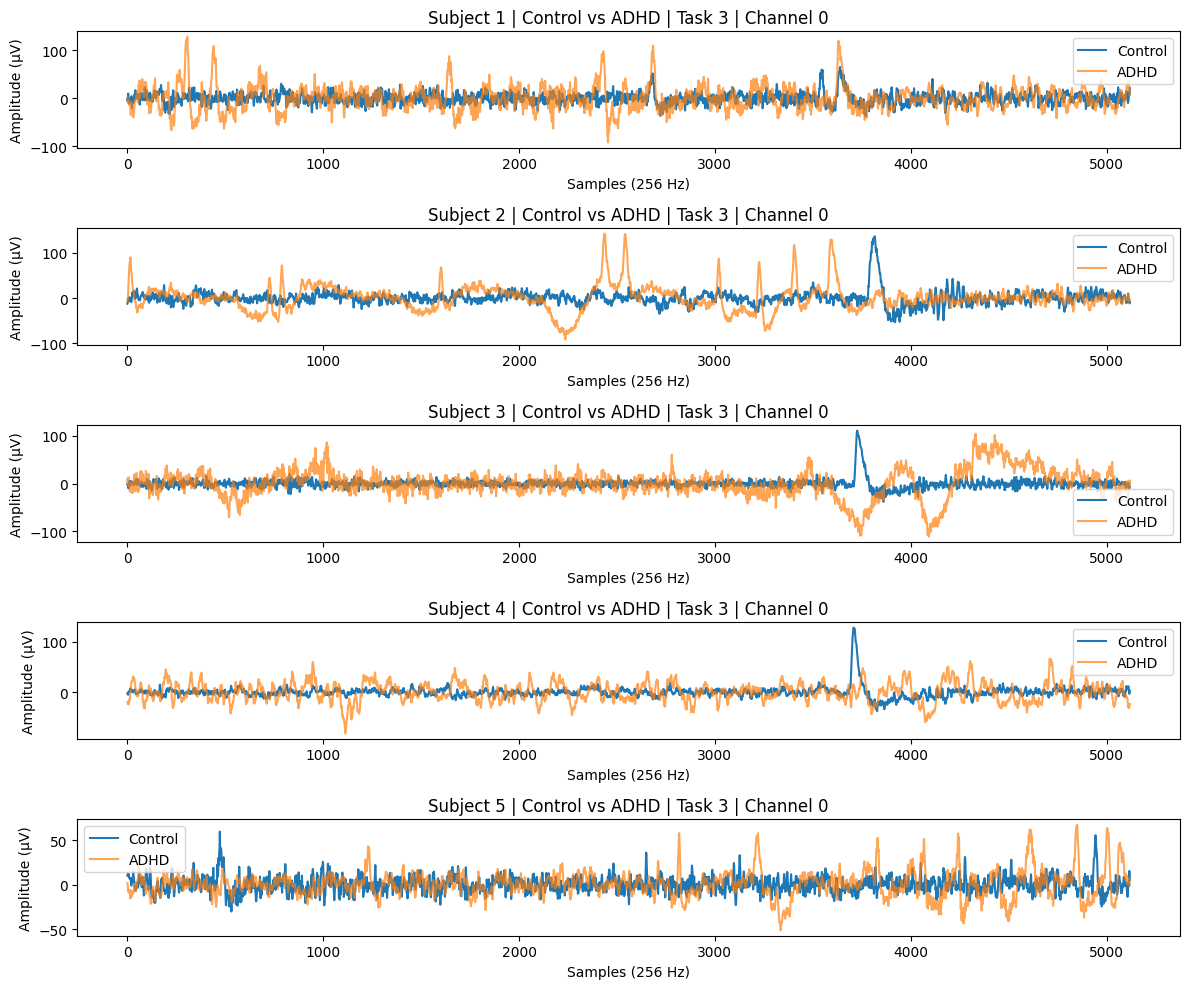

In [76]:
# Visualize the difference between ADHD and non for a task (for just one channel)
def visualize_adhd(control_df, adhd_df, channel=0, task=1, n=5):

    control_set = control_df[(control_df["task"] == task)].head(n)
    adhd_set = adhd_df[(adhd_df["task"] == task)].head(n)

    if control_set.empty or adhd_set.empty:
        print("No data found")
        return
    if channel > 1:
        print("Channel not found")
        return

    plt.figure(figsize=(12, 2 * n))

    for i in range(n):
        control_signal = control_set.iloc[i]["signal"]
        adhd_signal = adhd_set.iloc[i]["signal"]

        # plt.xlim(0, 2000)
        plt.subplot(n, 1, i + 1)
        plt.plot(control_signal[:, channel], label="Control")
        plt.plot(adhd_signal[:, channel], label="ADHD", alpha=0.7)
        plt.title(f"Subject {i+1} | Control vs ADHD | Task {task} | Channel {channel}")
        plt.xlabel("Samples (256 Hz)")
        plt.ylabel("Amplitude (µV)")
        plt.legend()

    plt.tight_layout()
    plt.show()

visualize_adhd(mc_df, madhd_df, channel=0, task=3, n=5)

# 2. Preprocessing

1. Detrend (remove mean)
2. Band-pass: 1–40 Hz (covers δ–β; trims slow drift + most EMG)
3. (Optional) Notch at 50 Hz if you see a strong line-noise peak
4. Fixed window: take the first 20 s of every recording (20 s × 256 Hz = 5120 samples) so durations match
5. Simple artifact reject: drop the window if |amplitude| > ±200 µV on either channel or if variance is tiny

## 2.1. Detrend (remove mean)

Mean before:  [1.52689479 0.09356797]
Mean after:  [-1.73564866e-15  1.18423789e-16]


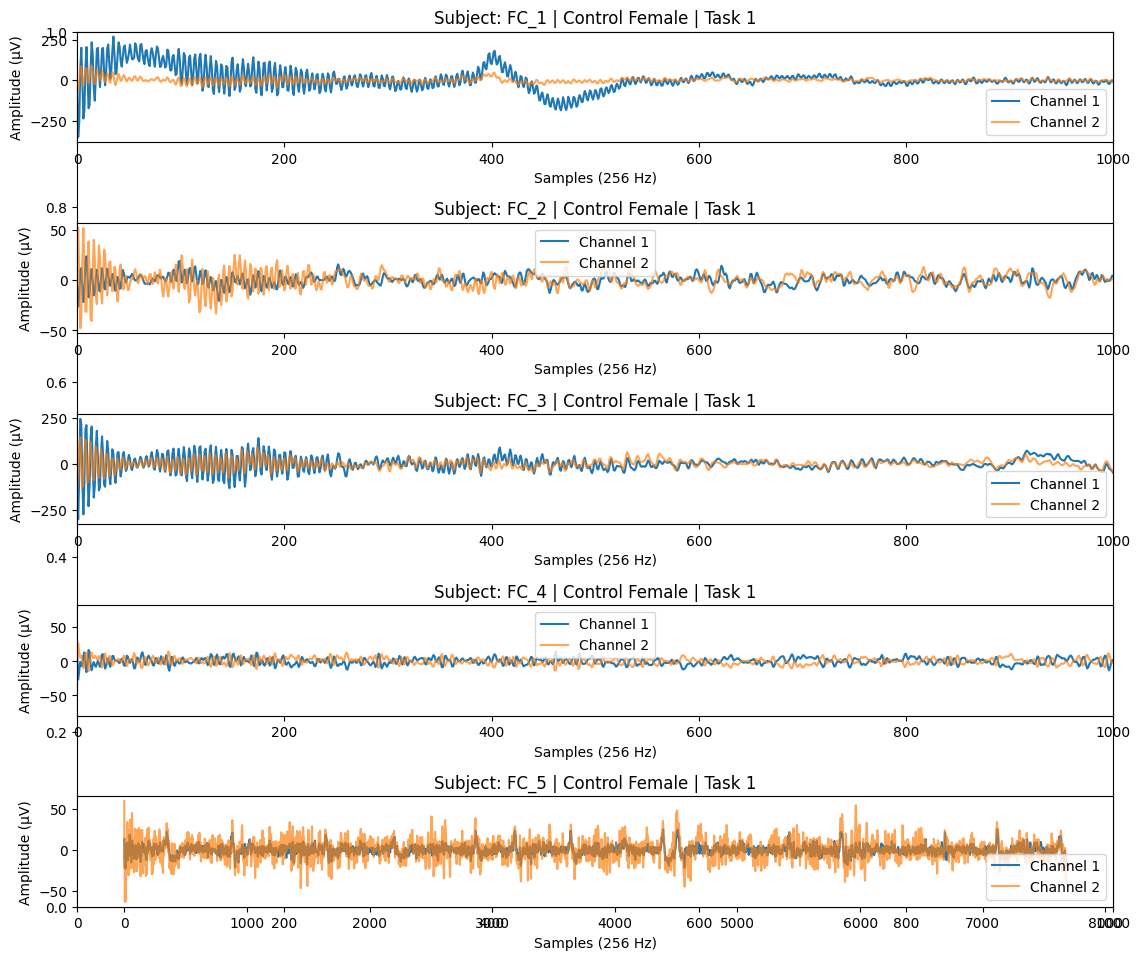

In [77]:
def detrend_signal(signal):
    return signal - np.mean(signal, axis=0, keepdims=True)

print("Mean before: ", np.mean(eeg_df['signal'][0], axis=0))

# eeg_df['signal'] = eeg_df['signal'].apply(detrend_signal)

# Using detrend function from scipy.signal
eeg_df['signal'] = eeg_df['signal'].apply(lambda s: detrend(s, axis=0))

print("Mean after: ", np.mean(eeg_df['signal'][0], axis=0))

visualize_task(eeg_df[:5], 'Control', 'Female', task=1, n=5)
# [-1.18423789e-16  1.48029737e-17]

Detrending subtracts a constant offset (or a slow slope).

It doesn’t change how the signal oscillates — the up-and-down pattern stays exactly the same.

Therefore, we can't really see any change between the first time we plot it without detrending and now, but if we look at the valuse of the means it is more visile.